In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/IS4303/notebooks/new_cleaned

Mounted at /content/drive
/content/drive/MyDrive/IS4303/notebooks/new_cleaned


# Helpers

In [ ]:
X_train = pd.read_csv('./5X_train.csv')
X_test = pd.read_csv('./4X_test.csv')
y_train = pd.read_csv('./5y_train.csv')
y_test = pd.read_csv('./4y_test.csv')
y_train = y_train['is_canceled']
y_test = y_test['is_canceled']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
def plot_preds(preds, probas, truth):
    auc_score = roc_auc_score(truth, probas)
    prec = precision_score(truth, preds)
    rec = recall_score(truth, preds)
    f1 = f1_score(truth, preds)
    print(f"AUC: {auc_score:.2f}\n")
    print(f'Precision: {prec:.2f}')
    print(f'Recall: {rec:.2f}')
    print(f"F1: {f1:.2f}\n")

    fpr, tpr, thresholds = roc_curve(truth, probas)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Initial model (final one below)
And a small test. Hyperparameter tuning below.

### Using XGBoost

This is with XGBoost, to test out performance.

In [ ]:
class RecallBooster(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, beta=0.5, threshold=0.5):
        self.n_estimators = n_estimators
        self.threshold = threshold
        self.beta = beta
        self.models = []

    def fit(self, X, y, feature_importance_threshold=0.1, random_state=None):
        skf = StratifiedKFold(n_splits=self.n_estimators, shuffle=True, random_state=random_state)

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model = XGBClassifier()
            model.fit(X_train, y_train, sample_weight=self._compute_sample_weights(X_train, y_train, feature_importance_threshold))
            self.models.append(model)
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for model in self.models:
            predictions += model.predict(X)
        return (predictions / len(self.models)) > self.threshold

    def predict_proba(self, X):
        probabilities = np.zeros((X.shape[0], 2))
        for model in self.models:
            probabilities += model.predict_proba(X)
        return probabilities / len(self.models)

    def _compute_sample_weights(self, X, y, feature_importance_threshold):
        feature_importances = np.mean([model.feature_importances_ for model in self.models], axis=0) if self.models else np.ones(X.shape[1])
        important_features = X.columns[feature_importances >= feature_importance_threshold * np.max(feature_importances)]
        X_imp = X[important_features]
        sample_weights = np.mean(np.abs(X_imp - X_imp.mean()), axis=1)
        sample_weights[y == 1] *= (y == 0).sum() / (y == 1).sum() * (1 + self.beta ** 2)
        return sample_weights

In [ ]:
clf = RecallBooster(threshold=0.5)
clf.fit(X_train, y_train)

RecallBooster()

AUC: 0.84

Precision: 0.56
Recall: 0.79
F1: 0.65



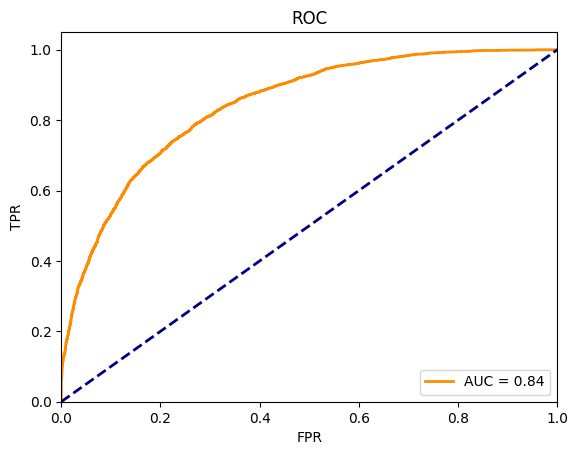

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)

### Using LGBM

This is with LGBM, which has a close performance. This takes much shorter, so it will be used for hyper-parameter tuning.

In [ ]:
class RecallBooster(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, beta=0.5, threshold=0.5):
        self.n_estimators = n_estimators
        self.threshold = threshold
        self.beta = beta
        self.models = []

    def fit(self, X, y, feature_importance_threshold=0.1, random_state=None):
        skf = StratifiedKFold(n_splits=self.n_estimators, shuffle=True, random_state=random_state)

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model = LGBMClassifier() # because xgb takes 15-25 mins per fit, and this has a very similar performance, with 1 min fits
            model.fit(X_train, y_train, sample_weight=self._compute_sample_weights(X_train, y_train, feature_importance_threshold))
            self.models.append(model)
        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for model in self.models:
            predictions += model.predict(X)
        return (predictions / len(self.models)) > self.threshold

    def predict_proba(self, X):
        probabilities = np.zeros((X.shape[0], 2))
        for model in self.models:
            probabilities += model.predict_proba(X)
        return probabilities / len(self.models)

    def _compute_sample_weights(self, X, y, feature_importance_threshold):
        feature_importances = np.mean([model.feature_importances_ for model in self.models], axis=0) if self.models else np.ones(X.shape[1])
        important_features = X.columns[feature_importances >= feature_importance_threshold * np.max(feature_importances)]
        X_imp = X[important_features]
        sample_weights = np.mean(np.abs(X_imp - X_imp.mean()), axis=1)
        sample_weights[y == 1] *= (y == 0).sum() / (y == 1).sum() * (1 + self.beta ** 2)
        return sample_weights

In [ ]:
clf = RecallBooster(threshold=0.5)
clf.fit(X_train, y_train)

RecallBooster()

AUC: 0.83

Precision: 0.53
Recall: 0.81
F1: 0.64



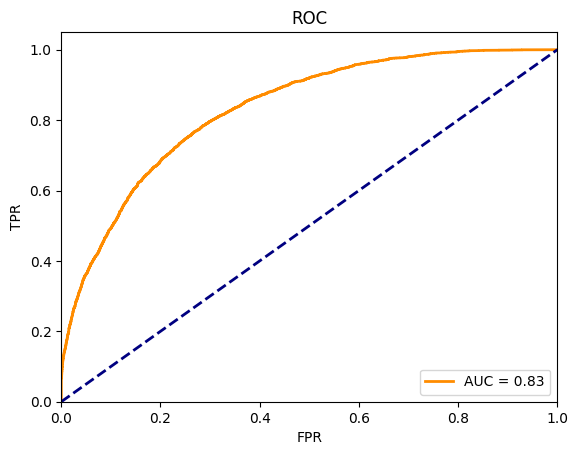

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)

# Final model

In [ ]:
class RecallBooster(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=5, beta=0.5, threshold=0.5, feature_imp_threshold=0.1):
        self.n_estimators = n_estimators
        self.threshold = threshold
        self.beta = beta
        self.feature_imp_threshold = feature_imp_threshold
        self.models = []

    def fit(self, X, y, feature_importance_threshold=0.1, random_state=None):
        skf = StratifiedKFold(n_splits=self.n_estimators, shuffle=True, random_state=random_state)

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model = LGBMClassifier() # because xgb takes 15-25 mins per fit, and this has a very similar performance, with 1 min fits
            model.fit(X_train, y_train, sample_weight=self._compute_sample_weights(X_train, y_train, self.feature_imp_threshold))
            self.models.append(model)

        return self

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for model in self.models:
            predictions += model.predict(X)

        return (predictions / len(self.models)) > self.threshold

    def predict_proba(self, X):
        probabilities = np.zeros((X.shape[0], 2))
        for model in self.models:
            probabilities += model.predict_proba(X)

        return probabilities / len(self.models)

    def _compute_sample_weights(self, X, y, feature_importance_threshold):
        feature_importances = np.mean([model.feature_importances_ for model in self.models], axis=0) if self.models else np.ones(X.shape[1])
        important_features = X.columns[feature_importances >= feature_importance_threshold * np.max(feature_importances)]
        X_imp = X[important_features]
        sample_weights = np.mean(np.abs(X_imp - X_imp.mean()), axis=1)
        sample_weights[y == 1] *= self.beta

        return sample_weights

# Hyperparameter tuning

Using LGBM 

In [ ]:
param_grid = {
    'n_estimators': [3, 5, 7],
    'threshold': [0.3, 0.5, 0.7],
    'beta': [1, 1.1, 1.3, 1.5, 1.7],
    'feature_imp_threshold': [0.1, 0.3, 0.5]
}

recall_booster = RecallBooster()

halving_grid_search = HalvingGridSearchCV(
    recall_booster,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)

halving_grid_search.fit(X_train, y_train)

print(f'Best params: {halving_grid_search.best_params_}')
print(f'Best F1: {halving_grid_search.best_score_:.4f}')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 880
max_resources_: 71340
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 880
Fitting 3 folds for each of 135 candidates, totalling 405 fits
----------
iter: 1
n_candidates: 45
n_resources: 2640
Fitting 3 folds for each of 45 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 15
n_resources: 7920
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 5
n_resources: 23760
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 71280
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'beta': 1.3, 'feature_imp_threshold': 0.3, 'n_estimators': 5, 'threshold': 0.3}
Best F1: 0.7893


In [ ]:
clf = RecallBooster(**halving_grid_search.best_params_)
clf.fit(X_train, y_train)

RecallBooster(beta=1.3, feature_imp_threshold=0.3, threshold=0.3)

AUC: 0.84

Precision: 0.52
Recall: 0.85
F1: 0.64



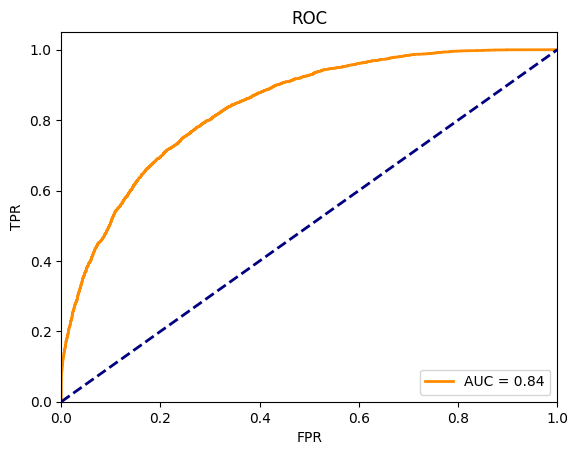

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]
plot_preds(y_pred, y_pred_proba, y_test)